In [2]:
import os
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from fastai.tabular.all import *
# from fastinference.tabular import *
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, SplineTransformer


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

warnings.simplefilter("ignore")

In [3]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
seed_everything(seed=42)

In [5]:
set_seed(42)
seed_everything(seed=42)

df_train = pd.read_csv("/content/imgs_2023071012133740345.csv",parse_dates=['Time'])
df_test = pd.read_csv("/content/imgs_202307101549519358.csv",parse_dates=['Time'])
df_cell = pd.read_csv("/content/imgs_2023071012130978799.csv",parse_dates=['Time'])
df_bs = pd.read_csv("/content/imgs_2023071012123392536.csv")
df_features = df_cell.merge(df_bs,on=['BS','CellName'],how='outer')
df_features = df_features[df_features['CellName']=='Cell0'].reset_index(drop=True)
df_test['split'] = 'test'
df_train['split'] = 'train'
df_total = pd.concat([df_train,df_test],ignore_index=True)
df_total = df_total.merge(df_features,on=['BS','Time'],how='left')
df_total['ID'] = df_total['Time'].astype(str)+"_"+df_total['BS']
df_total['BS'] = df_total['BS'].str.replace(r'[a-zA-Z_]', '', regex=True).astype(int)
for col in ['RUType','Mode']:
    df_total[col] = df_total[col].str.replace(r'[a-zA-Z]', '', regex=True).astype(int)

df_total.sort_values(['BS','Time'], ascending=True,ignore_index=True,inplace=True)
df_total['day'] = df_total['Time'].dt.day
df_total['weekday_number'] = df_total['Time'].dt.weekday
df_total['hour'] = df_total['Time'].dt.hour

hour_df = df_total[['hour']].copy()
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(splines,columns=[f"hour_spline_{i}" for i in range(splines.shape[1])])
df_total = pd.concat([df_total,splines_df],axis=1)

df_total = df_total.sort_values(['BS','Time'],ascending=True,ignore_index=True)
all_shits = list(np.arange(1,4)) #
for shift_i in tqdm(all_shits):
    for col in ['load','ESMode1','ESMode2','ESMode3','ESMode6','Time','Energy']:
        df_total[f'{col}_T-{shift_i}'] = df_total.groupby(['BS'])[col].shift(shift_i)
for shift_i in tqdm(all_shits):
    df_total[f'Time_T-{shift_i}_hours_elapsed'] = (df_total[f'Time_T-{shift_i}']-df_total['Time']).dt.total_seconds() / 3600
    del df_total[f'Time_T-{shift_i}']
print(df_total.shape)

num_bins = 100
df_total['load_bin'] = pd.cut(df_total['load'],bins=[round(i,2) for i in list(np.arange(0,1.01,0.01))],labels=[f'{i}' for i in range(num_bins)])
df_total['load_bin'] = df_total['load_bin'].astype(float).fillna(-1).astype(int)

print(df_total.shape)

100%|██████████| 3/3 [00:00<00:00, 185.64it/s]

(118768, 56)
(118768, 57)


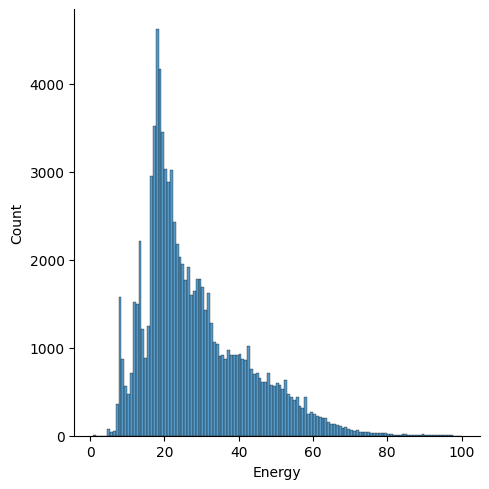

In [6]:
sns.displot(df_total['Energy'])

<Axes: xlabel='Time'>

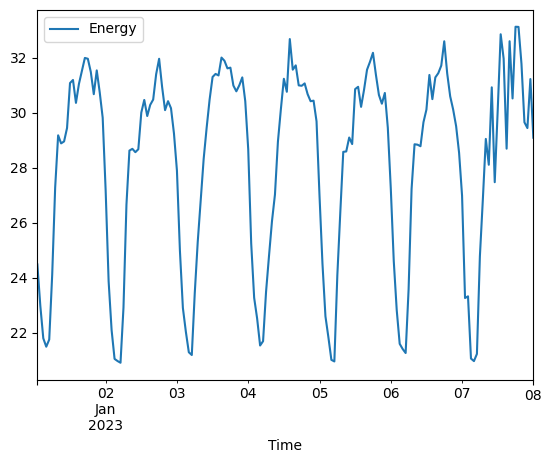

In [7]:
df_total.groupby(['Time'])[['Energy']].mean().plot()

<Axes: xlabel='load'>

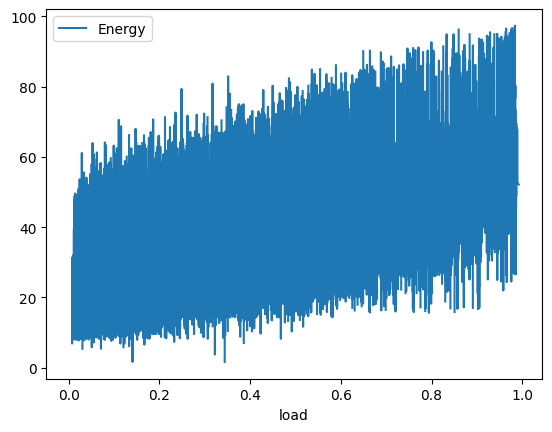

In [8]:
df_total.groupby(['load'])[["Energy"]].mean().plot()

In [9]:
set_seed(42)
seed_everything(seed=42)

from scipy.signal import savgol_filter as sg
from scipy.signal import sosfiltfilt, butter, sosfilt, sosfilt_zi

def add_sg(df):
    w = 5 #5
    p = 3 #2
    for si in tqdm(df.BS.unique()):
        index = df.BS == si
        df.loc[index, 'load_smooth'] = sg(df[index].load, w, p)
        df.loc[index, 'load_diff'] = sg(df[index].load, w, p, 1)
        df.loc[index, 'load_diff2'] = sg(df[index].load, w, p, 2)
        df.loc[index, 'load_diff3'] = sg(df[index].load, w, p, 3)

add_sg(df_total)
print(df_total.shape)

def add_sosfiltfilt(df):
    for si in tqdm(df.BS.unique()):
        index = df.BS == si
        sos=butter(4, 0.125, output='sos')
        sos8 = butter(8, 0.125, output='sos')
        zi = np.array(df[index].load[:4]).mean() * sosfilt_zi(sos8)
        df.loc[index, 'load_sosfiltfilt'] = sosfiltfilt(sos,df[index].load)
        df.loc[index, 'load_sosfilt'], _ = sosfilt(sos8, df[index].load, zi=zi)

add_sosfiltfilt(df_total)
print(df_total.shape)

100%|██████████| 1020/1020 [00:08<00:00, 115.71it/s]


(118768, 61)


100%|██████████| 1020/1020 [00:05<00:00, 170.82it/s]

(118768, 63)


In [10]:

set_seed(42)
seed_everything(seed=42)

df_total.drop(columns=['w','CellName','ESMode4','Time'],inplace=True)

id_variable = 'ID'
version_nb = 'v4'
TARGET = 'Energy'

train_df = df_total[df_total['split']=='train'].reset_index(drop=True)
test_df = df_total[df_total['split']=='test'].reset_index(drop=True)
train_cols = [i for i in train_df if i not in ['Time','CellName','ID','Energy','split','w','BS','ESMode6']]

categorical_cols = ['RUType','Mode','load_bin']

print(train_df[train_cols].shape, test_df[train_cols].shape)

(92629, 54) (26139, 54)


In [11]:
set_seed(42)
seed_everything(seed=42)

remove_non_unique_cols = []
print('train single values ..')
for col in train_df:
    if col in train_cols and col not in ['ESMode5']:
        if train_df[col].nunique()<=1:
            remove_non_unique_cols.append(col)
            print(col,":",train_df[col].nunique())
print('test single values ..')
for col in test_df:
    if col in train_cols and col not in ['ESMode5']:
        if test_df[col].nunique()<=1:
            remove_non_unique_cols.append(col)
            print(col,":",test_df[col].nunique())

print('\n',remove_non_unique_cols)

for col in train_df:
    if col in train_cols:
        if train_df[col].isnull().sum()/len(train_df)>=0.95:
            print(col,":",train_df[col].isnull().sum()/len(train_df))
            remove_non_unique_cols.append(col)

for col in test_df:
    if col in train_cols:
        if test_df[col].isnull().sum()/len(test_df)>=0.95:
            print(col,":",test_df[col].isnull().sum()/len(test_df))
            remove_non_unique_cols.append(col)

print(len(train_cols))
train_cols = [col for col in train_cols if col not in remove_non_unique_cols]
print(len(train_cols))
print(train_cols)

train single values ..
test single values ..

 []
54
54
['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5', 'RUType', 'Mode', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'day', 'weekday_number', 'hour', 'hour_spline_0', 'hour_spline_1', 'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5', 'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9', 'hour_spline_10', 'hour_spline_11', 'load_T-1', 'ESMode1_T-1', 'ESMode2_T-1', 'ESMode3_T-1', 'ESMode6_T-1', 'Energy_T-1', 'load_T-2', 'ESMode1_T-2', 'ESMode2_T-2', 'ESMode3_T-2', 'ESMode6_T-2', 'Energy_T-2', 'load_T-3', 'ESMode1_T-3', 'ESMode2_T-3', 'ESMode3_T-3', 'ESMode6_T-3', 'Energy_T-3', 'Time_T-1_hours_elapsed', 'Time_T-2_hours_elapsed', 'Time_T-3_hours_elapsed', 'load_bin', 'load_smooth', 'load_diff', 'load_diff2', 'load_diff3', 'load_sosfiltfilt', 'load_sosfilt']


In [12]:
set_seed(42)
seed_everything(seed=42)

Nfold = 10
Inference=False

if Inference:
    print('Data has been splitted...')
else:
    train_df['fold'] = 0
    strafy_bin = train_df['BS'].astype('int')

    skf = GroupKFold(n_splits = Nfold)
    for i, (_, train_index) in enumerate(skf.split(train_df.index,train_df.index, strafy_bin)):
        train_df.loc[train_index, 'fold'] = i

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch

In [14]:
df1 = pd.read_csv("/content/imgs_2023071012130978799.csv", parse_dates=['Time'])
df2 = pd.read_csv("/content/imgs_202307101549519358.csv", parse_dates=['Time'])
df3 = pd.read_csv("/content/imgs_2023071012133740345.csv", parse_dates=['Time'])
df4 = pd.read_csv("/content/imgs_2023071012123392536.csv")

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

In [24]:
# Generator network
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.Sigmoid()  # Output is scaled between 0 and 1 (energy consumption)
        )

    def forward(self, x):
        return self.model(x)

In [25]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output is a probability between 0 and 1 (real or fake)
        )

    def forward(self, x):
        return self.model(x)

In [46]:
# Define the input and output sizes
input_size = 100  # Input size for the generator (noise vector)
output_size = 1  # Output size for the generator (energy consumption)

# Initialize the generator and discriminator
generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

# Print the architectures of the generator and discriminator
print("Generator architecture:")
print(generator)

print("\nDiscriminator architecture:")
print(discriminator)

Generator architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generator network
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.Tanh()  # Output is scaled between -1 and 1
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output is a probability between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

# Define the input and output sizes
input_size = 100  # Input size for the generator (noise vector)
output_size = len(df1.columns)  # Output size for the generator (number of features)

# Initialize the generator and discriminator
generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

# Print the architectures of the generator and discriminator
print("Generator architecture:")
print(generator)

print("\nDiscriminator architecture:")
print(discriminator)


Generator architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): Tanh()
  )
)

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [48]:

# Generate synthetic data
num_samples = 1000  # Number of synthetic samples to generate
noise = torch.randn(num_samples, input_size)  # Generate random noise
synthetic_data = generator(noise).detach().numpy()  # Generate synthetic data

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=df1.columns)  # Assuming df1 contains the column names

# Display the generated synthetic data
print("Generated Synthetic Data:")
print(synthetic_df.head())


Generated Synthetic Data:
       Time        BS  CellName      load   ESMode1   ESMode2   ESMode3  \
0 -0.099160  0.070467  0.082411 -0.164746 -0.041833 -0.174981  0.106421   
1  0.036482  0.096329  0.195481 -0.150453 -0.182003 -0.004675  0.095207   
2  0.047509  0.065716  0.131236  0.011012 -0.029638 -0.010129  0.071847   
3 -0.026452  0.094627  0.161495 -0.033411  0.015911 -0.036418  0.009706   
4 -0.062390  0.146169 -0.004990 -0.088107 -0.151621 -0.090339  0.004429   

    ESMode4   ESMode5   ESMode6  
0  0.035789 -0.141139 -0.170357  
1  0.059426 -0.084605 -0.068326  
2  0.005931 -0.007267  0.008801  
3  0.074431 -0.046578 -0.090183  
4  0.055383 -0.102316 -0.090325  


Data loaded successfully!
Number of rows and columns in the data: (125575, 10)


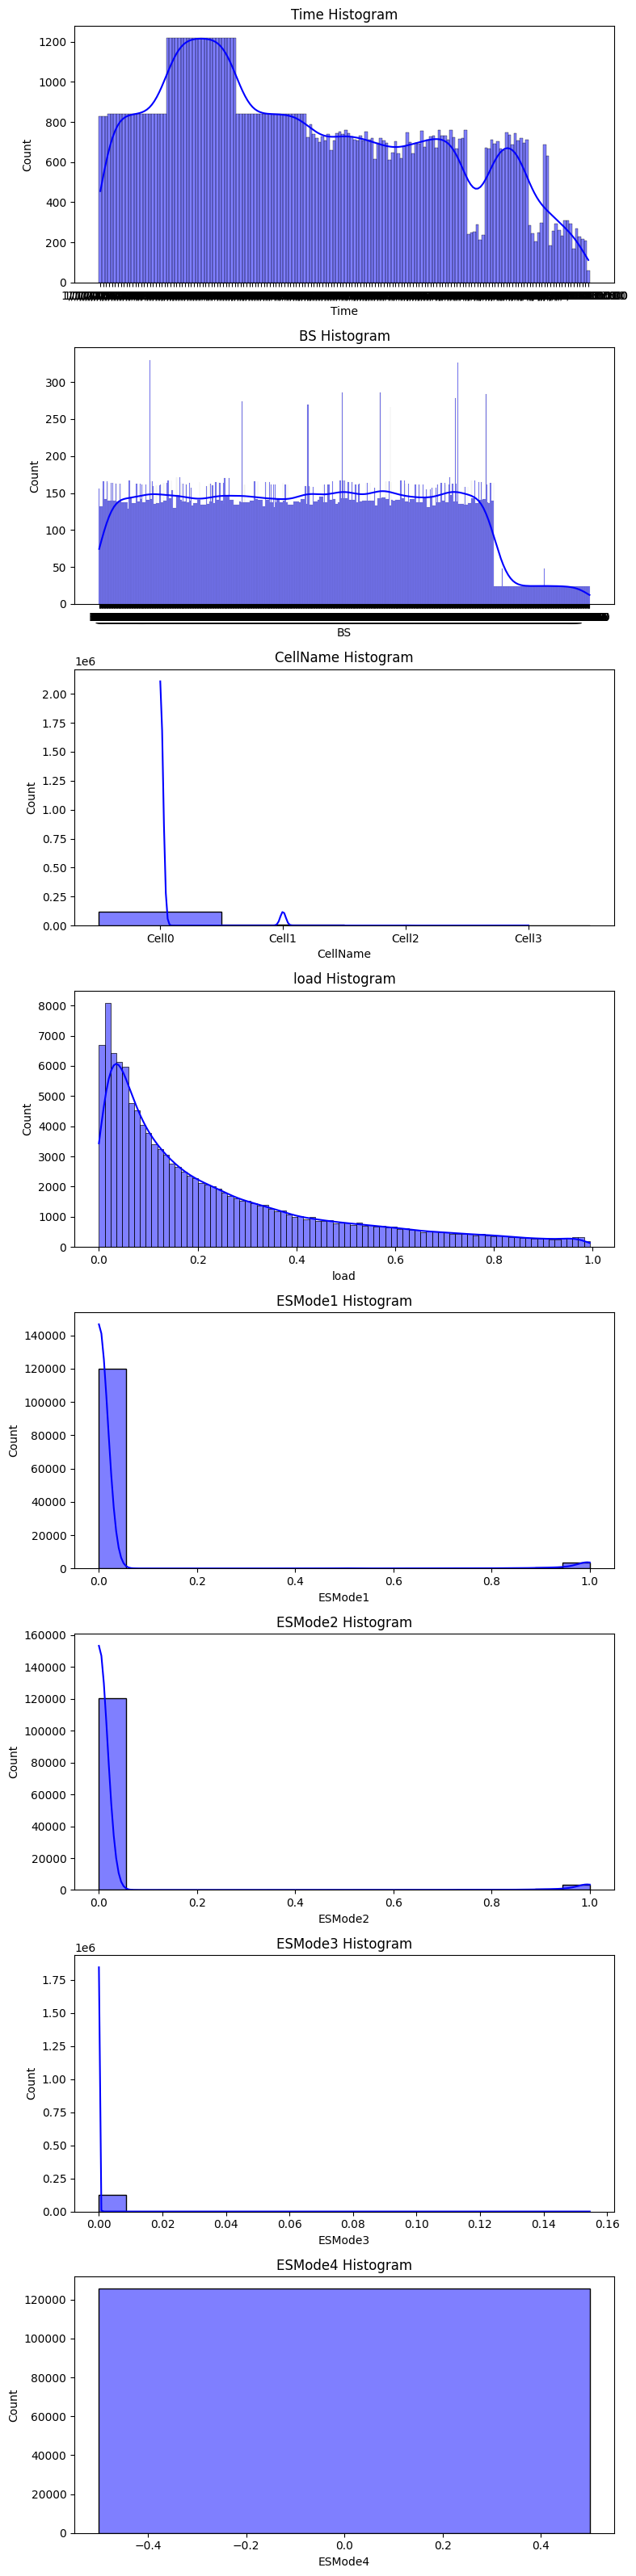

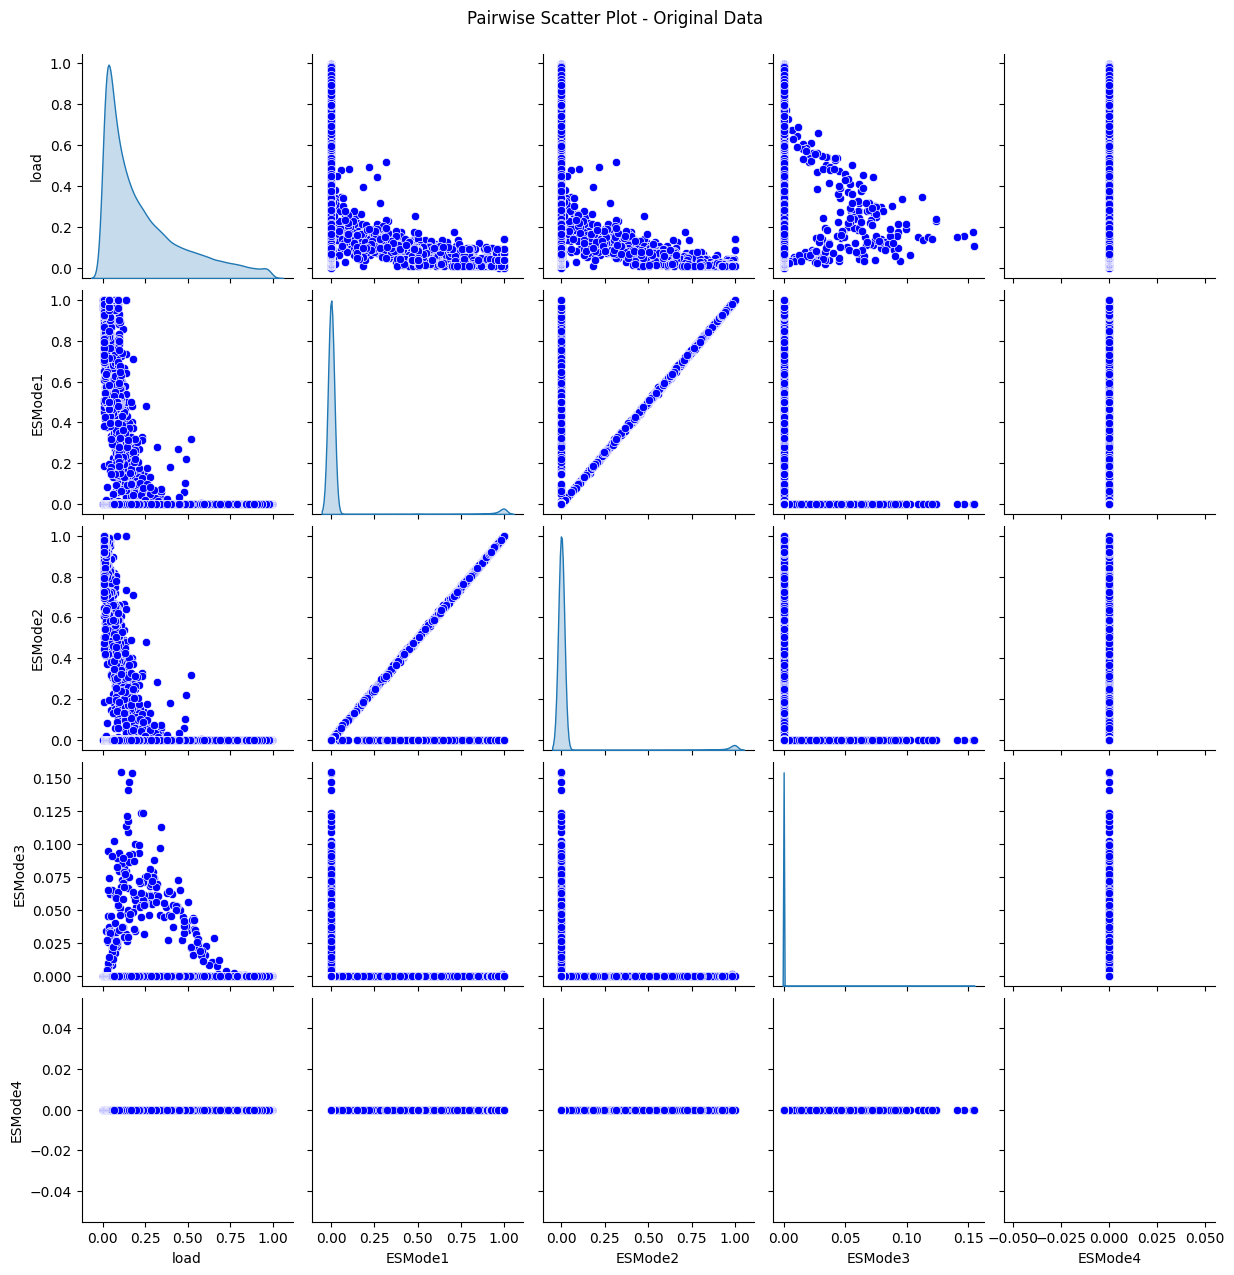

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms for selected features
def plot_histograms(original_data, feature_names):
    num_features = len(feature_names)
    fig, axs = plt.subplots(num_features, 1, figsize=(8, num_features * 4))
    for i, feature in enumerate(feature_names):
        sns.histplot(original_data[feature], ax=axs[i], kde=True, color='blue')
        axs[i].set_title(f'{feature} Histogram')
    plt.tight_layout()
    plt.show()

# Function to plot pairwise scatter plots for selected features
def plot_pairwise_scatter(original_data, feature_names):
    sns.pairplot(original_data[feature_names], diag_kind='kde', plot_kws={'color':'blue'}, height=2.5)
    plt.suptitle("Pairwise Scatter Plot - Original Data", y=1.02)
    plt.show()

# Load your original data from a CSV file
# Replace 'path_to_original_data_file.csv' with the path to your original data file
original_data = pd.read_csv('/content/imgs_2023071012130978799.csv')

# Check if data is loaded correctly
print("Data loaded successfully!")
print("Number of rows and columns in the data:", original_data.shape)

# Select a few features for visualization
# Select a few features for visualization
selected_features = ['Time', 'BS', 'CellName', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode4']


# Check if selected features exist in the data
for feature in selected_features:
    if feature not in original_data.columns:
        print(f"Warning: Feature '{feature}' not found in the data!")

# Plot histograms and pairwise scatter plots for the original data
if not original_data.empty:
    plot_histograms(original_data, selected_features)
    plot_pairwise_scatter(original_data, selected_features)
else:
    print("Error: No data loaded or empty DataFrame!")
